In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to C:\Users\Co2fi-
[nltk_data]     crs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('../data/anonymized/')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils
print(rpath)

c:\Users\Co2fi-crs\Documents\crs\Git\10Academy\week0_starter_network_analysis\data\anonymized


### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [4]:
 
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [31]:
def get_top_10_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:10].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

#### Importing and loading data

In [34]:
import src.loader as loader
# Initialize SlackDataLoader
data_loader = SlackDataLoader(rpath)

# Load data from a Slack channel
slack_data_user = data_loader.get_users()
slack_data_channel = data_loader.get_channels()
slack_data_usermap = data_loader.get_user_map()
slack_data_user
slack_data_user[2]['id']
    

'U03TNP8Q8CT'

##### Get the different data

In [28]:

# channel path
path_channel = os.path.abspath('../data/anonymized/all-week8')
print(path_channel)
dataf = loader.slack_parser(path_channel)
display(dataf.head(2))

data2 = loader.parse_slack_reaction(path_channel, 'all-week8')
display(data2.head(2))

c:\Users\Co2fi-crs\Documents\crs\Git\10Academy\week0_starter_network_analysis\data\anonymized\all-week8


,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,Good morning everyone :blush: welcome to week ...,Garrett Bell,1665385707.569729,text,0,0,0,0,0,c:\Users\Co2fi-crs\Documents\crs\Git\10Academy...
1,message,Good morning!,Carlos Gross,1665385734.616309,text,0,0,0,0,0,c:\Users\Co2fi-crs\Documents\crs\Git\10Academy...


,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
0,raised_hands,10,"U03UL5LSTG9,U03V785NLSU,U03UUR571A5,U03V61VGQG...",Good morning everyone :blush: welcome to week ...,U03TEPYRM2P,all-week8
1,clap,1,U03UUMR26Q1,Good morning everyone :blush: welcome to week ...,U03TEPYRM2P,all-week8


### top 10 and 10 bottoms users

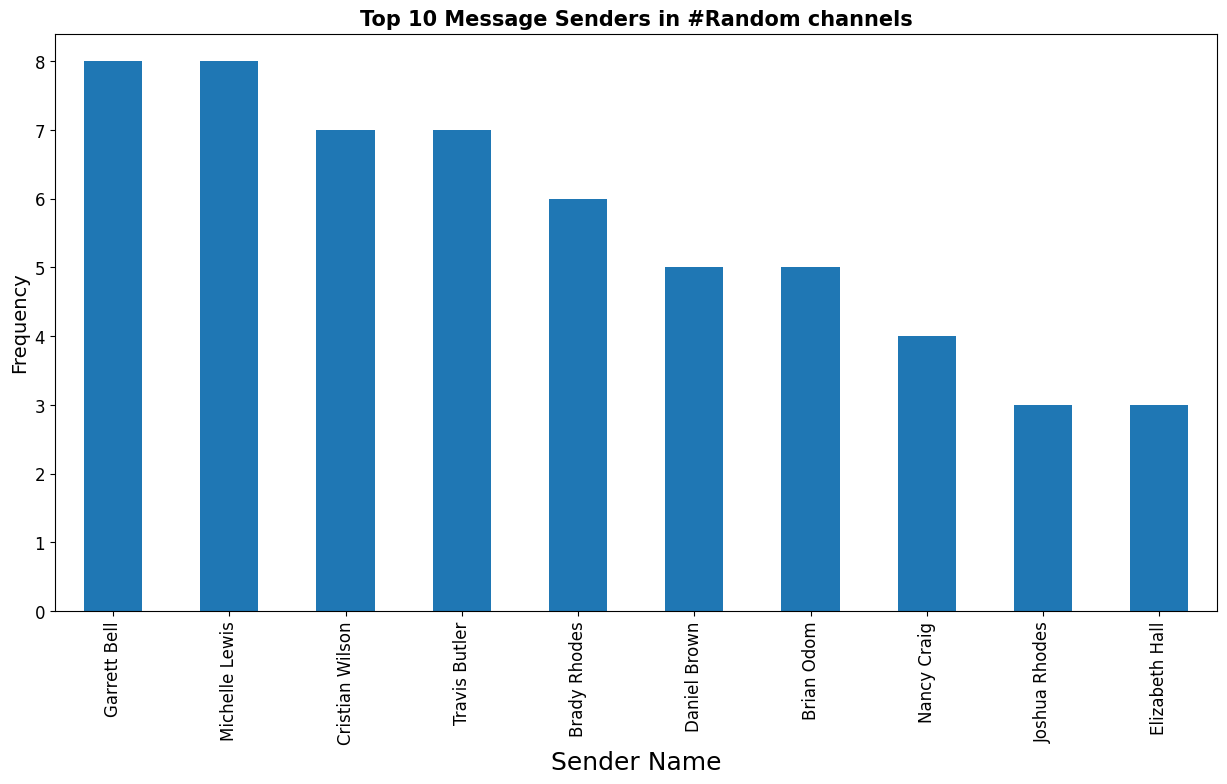

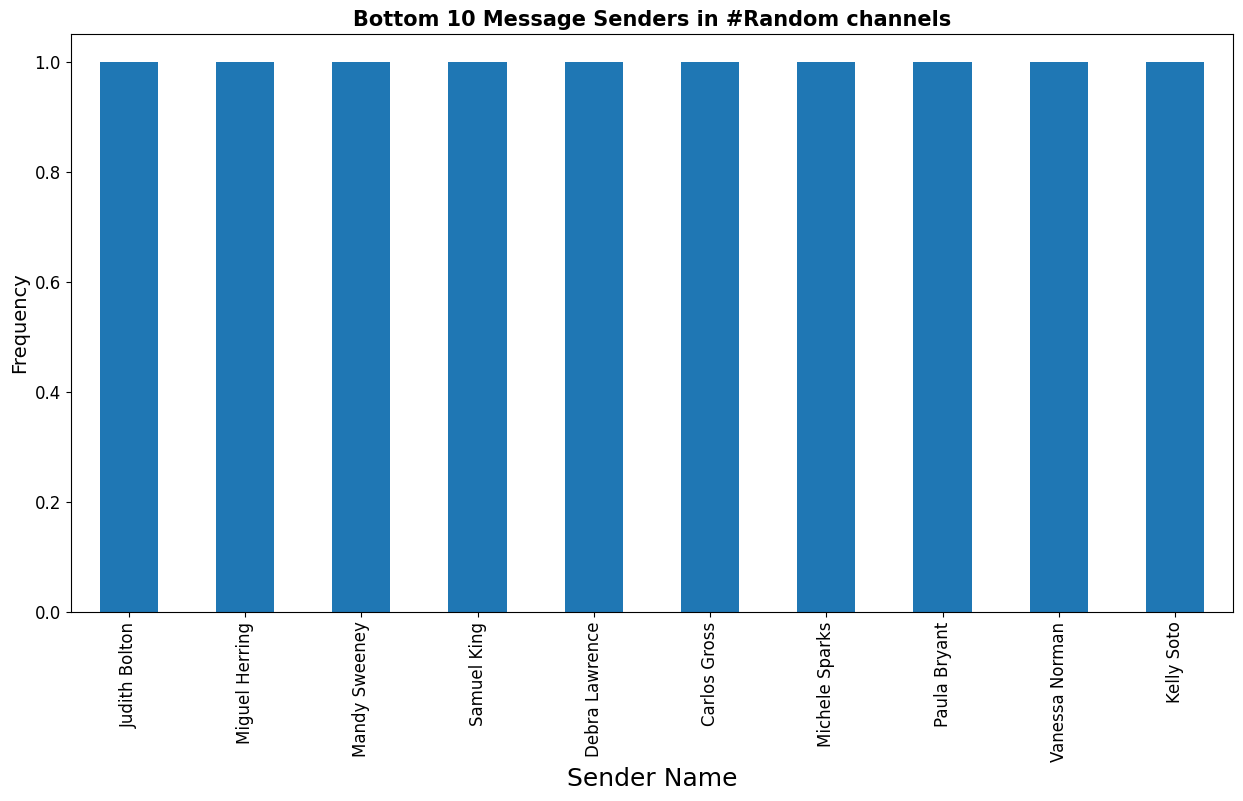

In [32]:
get_top_10_user(dataf, channel='Random')

#### Average number of user reply _ Count per sender

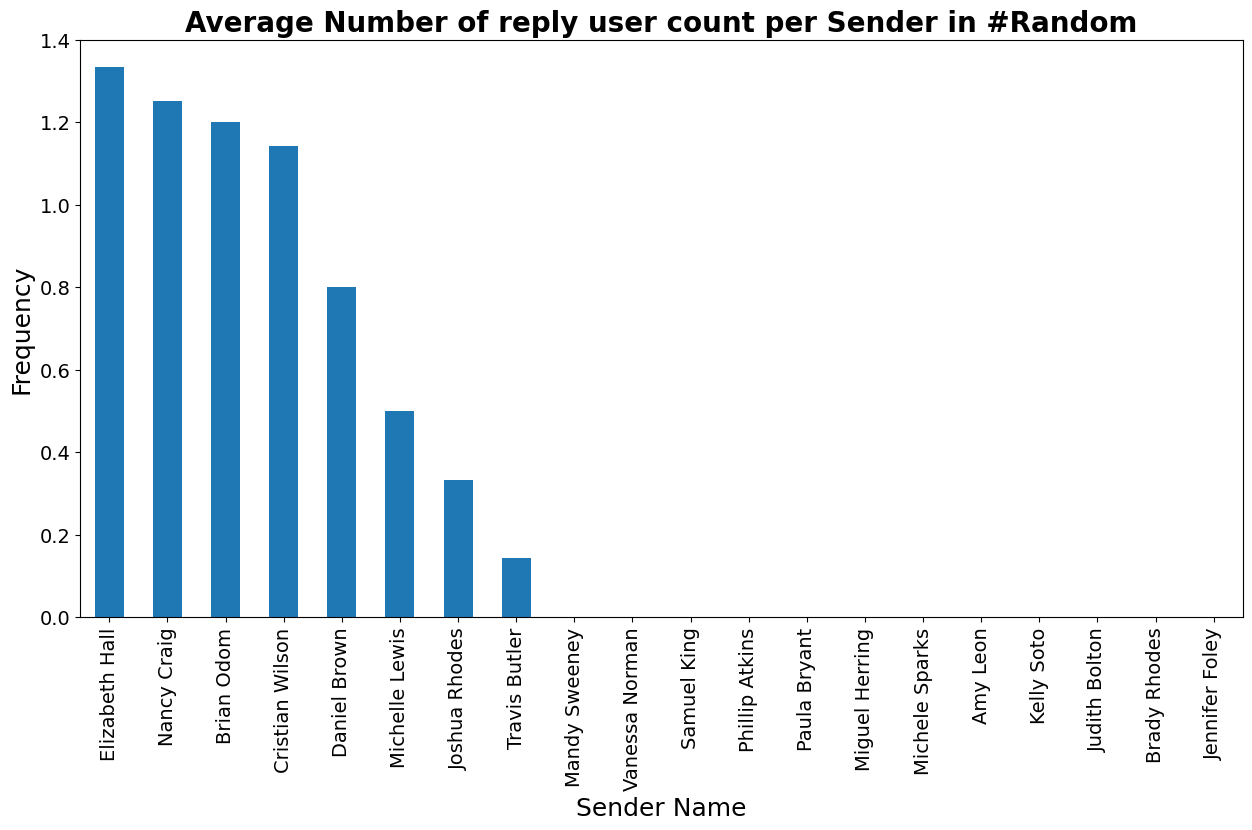

In [36]:
draw_avg_reply_users_count(dataf, channel='Random')

#### User with the most reaction

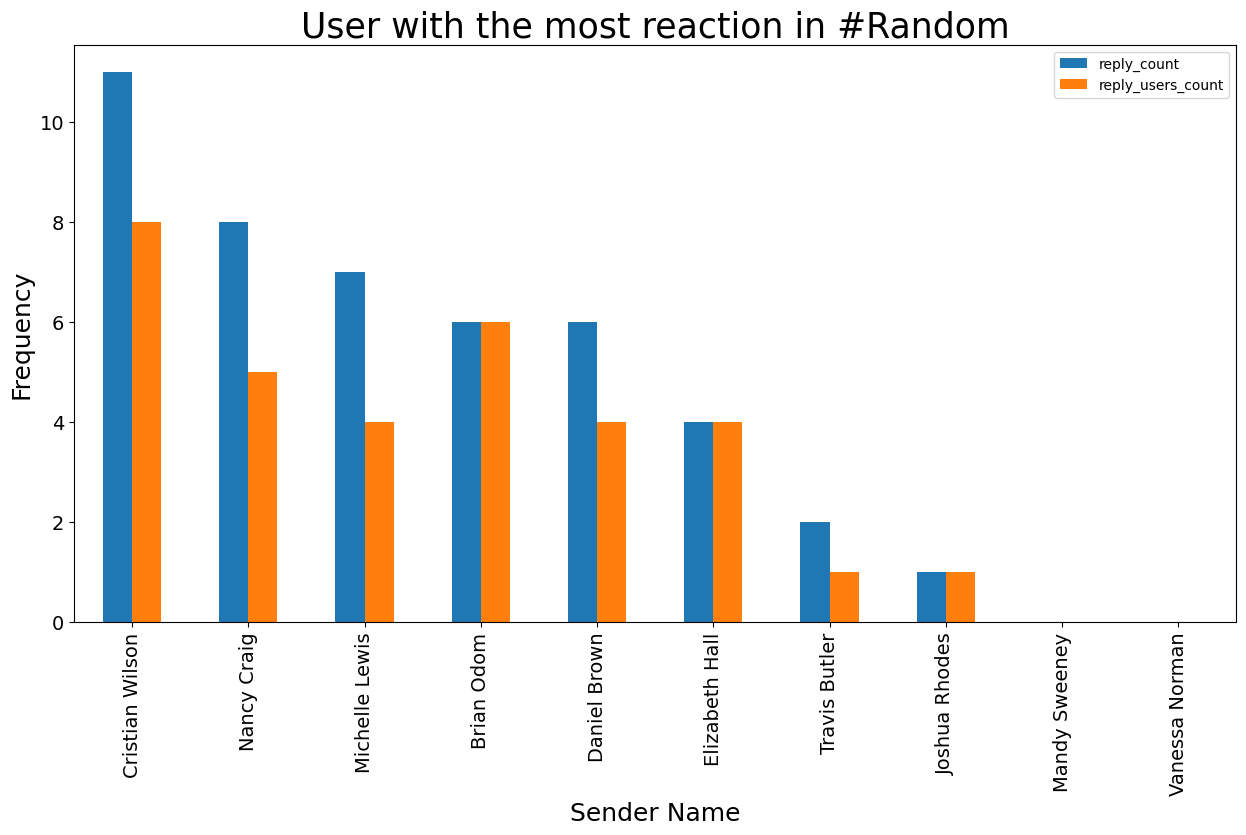

In [35]:
draw_user_reaction(dataf, channel='Random')

#### Word Cloud Visualization

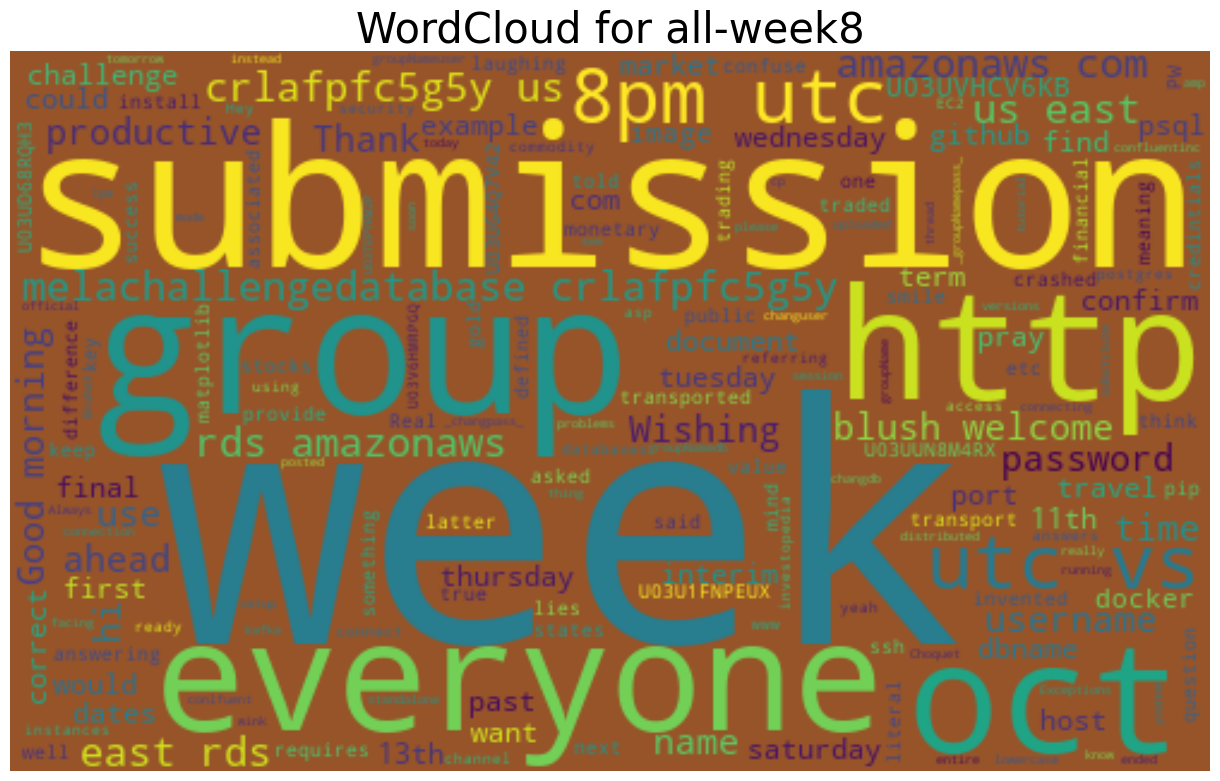

In [10]:
loader.get_community_participation(path_channel)
draw_wordcloud(data2['message'], 'all-week8')

In [11]:
# which user has the highest number of reply counts?

In [12]:
# Visualize reply counts per user per channel

In [13]:
# what is the time range of the day that most messages are sent?


In [14]:
# what kind of messages are replied faster than others?

In [15]:
# Relationship between # of messages and # of reactions

In [16]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [17]:
# Which users got the most reactions?

In [18]:
# Model topics mentioned in the channel

In [19]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [20]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?